In [1]:
###### import commands
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.utils import resample

In [2]:
#### read model
df=pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory=False)
df=df.set_index('ticket_id')
dfOG=df.copy()

In [3]:
#### read the test model so we match columns
dftest=pd.read_csv('test.csv')
dftest=dftest.set_index('ticket_id')


In [4]:
#### create new feature - time difference between ticket and hearing dates
tdiff=pd.to_datetime(dfOG['hearing_date'])-pd.to_datetime(dfOG['ticket_issued_date'])
dfOG['TimeDiff']=tdiff.dt.total_seconds()/86400
tdiff=pd.to_datetime(dftest['hearing_date'])-pd.to_datetime(dftest['ticket_issued_date'])
dftest['TimeDiff']=tdiff.dt.total_seconds()/86400
dftest.head()


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,...,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,TimeDiff
ticket_id,,,,,,,,,,,,,,,,,,,,,
284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,MI,...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN,14.791667
285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN,31.965278
285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN,31.965278
285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,MI,...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN,32.940972
285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,MI,...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN,39.944444


In [5]:
#### add month feature for issue and hearing date, also day and weekday
dftest['hearing_month']=pd.to_datetime(dftest['hearing_date']).dt.month
dfOG['hearing_month']=pd.to_datetime(dfOG['hearing_date']).dt.month
dftest['issue_month']=pd.to_datetime(dftest['ticket_issued_date']).dt.month
dfOG['issue_month']=pd.to_datetime(dfOG['ticket_issued_date']).dt.month

dftest['hearing_day']=pd.to_datetime(dftest['hearing_date']).dt.day
dfOG['hearing_day']=pd.to_datetime(dfOG['hearing_date']).dt.day
dftest['issue_day']=pd.to_datetime(dftest['ticket_issued_date']).dt.day
dfOG['issue_day']=pd.to_datetime(dfOG['ticket_issued_date']).dt.day

dftest['hearing_dayofweek']=pd.to_datetime(dftest['hearing_date']).dt.weekday
dfOG['hearing_dayofweek']=pd.to_datetime(dfOG['hearing_date']).dt.weekday
dftest['issue_dayofweek']=pd.to_datetime(dftest['ticket_issued_date']).dt.weekday
dfOG['issue_dayofweek']=pd.to_datetime(dfOG['ticket_issued_date']).dt.weekday

dftest.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,...,clean_up_cost,judgment_amount,grafitti_status,TimeDiff,hearing_month,issue_month,hearing_day,issue_day,hearing_dayofweek,issue_dayofweek
ticket_id,,,,,,,,,,,,,,,,,,,,,
284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,MI,...,0.0,250.0,NaN,14.791667,1.0,1,19.0,4,3.0,2
285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,...,0.0,1130.0,NaN,31.965278,2.0,1,6.0,5,0.0,3
285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,...,0.0,140.0,NaN,31.965278,2.0,1,6.0,5,0.0,3
285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,MI,...,0.0,250.0,NaN,32.940972,2.0,1,7.0,5,1.0,3
285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,MI,...,0.0,140.0,NaN,39.944444,2.0,1,14.0,5,1.0,3


In [6]:
#### change the violation code

dfOG['violation_code']=dfOG['violation_code'].apply(lambda x: x.split('-')[0])
dftest['violation_code']=dftest['violation_code'].apply(lambda x: x.split('-')[0])
dftest['violation_code'].unique()

array(['22', '9', '61', '20130901', '19910901', '19420901', '19450901',
       '19410901', '20180901', '19830901'], dtype=object)

In [7]:
#### make violation_description for both
dfplay1=dfOG.copy()
dfplay2=dftest.copy()

## merge them temporarily
dfplay1['test']=0
dfplay2['test']=1
dfplay0=pd.concat([dfplay1,dfplay2],sort=True)


dfplay0.violation_description=dfplay0.violation_description.astype("category").cat.codes

## this shows how many of each description there are, only choose the ones with a lot
tot=dfplay0.violation_description.value_counts() # already sorted
iMajor=list(tot.index[tot>400]) # these are the label codes for the ones with a lot of hits

## keep the good ones, label the rest the same
dfplay0.violation_description=dfplay0.violation_description.apply(lambda x: x if x in iMajor else -1)
dfplay0.violation_description=dfplay0.violation_description.astype('category')

dfOG=dfplay0[dfplay0.test==0]
dftest=dfplay0[dfplay0.test==1]

In [8]:
#### read latlon, addresses
latlon_df=pd.read_csv('latlons.csv')
add_df=pd.read_csv('addresses.csv')
# add_df=add_df.set_index('ticket_id')
# add_df['address']
add_df['address'] = add_df['address'].str.upper()
# add_df.head()

In [9]:
#### merge latlon, addresses on addresses column

# latlon_df['address']
latlon_df['address'] = latlon_df['address'].str.upper()
latlon_df.head()

df_info=add_df.merge(latlon_df,left_on='address',right_on='address')
df_info=df_info.set_index('ticket_id')
print('add={:d} + ll={:d} = {:d}'.format(len(add_df),len(latlon_df),len(df_info)))

# there should be 8 rows with nan lat/lon
# df_info['lon'].isna().sum() # =8
# df_info.head()


add=311307 + ll=121769 = 311307


In [10]:
#### merge latlon info into main df
df2=dfOG.merge(df_info,left_index=True,right_index=True, how='left')
print('og={:d} + info={:d} = {:d}'.format(len(dfOG),len(df_info),len(df2)))
dfOG=df2.copy()
df=df2.copy()

#### and do the same for the test dataset
dftest2=dftest.merge(df_info,left_index=True,right_index=True, how='left')
print('og={:d} + info={:d} = {:d}'.format(len(dftest),len(df_info),len(dftest2)))

og=250306 + info=311307 = 250306
og=61001 + info=311307 = 61001


In [11]:
#### show column names
df.columns

Index(['TimeDiff', 'admin_fee', 'agency_name', 'balance_due', 'city',
       'clean_up_cost', 'collection_status', 'compliance', 'compliance_detail',
       'country', 'discount_amount', 'disposition', 'fine_amount',
       'grafitti_status', 'hearing_date', 'hearing_day', 'hearing_dayofweek',
       'hearing_month', 'inspector_name', 'issue_day', 'issue_dayofweek',
       'issue_month', 'judgment_amount', 'late_fee',
       'mailing_address_str_name', 'mailing_address_str_number',
       'non_us_str_code', 'payment_amount', 'payment_date', 'payment_status',
       'state', 'state_fee', 'test', 'ticket_issued_date', 'violation_code',
       'violation_description', 'violation_street_name',
       'violation_street_number', 'violation_zip_code', 'violator_name',
       'zip_code', 'address', 'lat', 'lon'],
      dtype='object')

In [1046]:
#### example row
df.iloc[0]

TimeDiff                                                             369.951
admin_fee                                                                 20
agency_name                   Buildings, Safety Engineering & Env Department
balance_due                                                              305
city                                                                 CHICAGO
clean_up_cost                                                              0
collection_status                                                        NaN
compliance                                                                 0
compliance_detail                                non-compliant by no payment
country                                                                  USA
discount_amount                                                            0
disposition                                           Responsible by Default
fine_amount                                                              250

In [12]:
#### define features to use and clean model
target='compliance'
# usecols=['disposition', 'agency_name', 'late_fee', 'fine_amount']
# usecols=['disposition', 'agency_name', 'late_fee','discount_amount', 'fine_amount','judgment_amount','TimeDiff','issue_month','hearing_month','hearing_day','hearing_dayofweek','issue_dayofweek','violation_description']
usecols=['disposition', 'agency_name', 'late_fee','discount_amount', 'fine_amount','judgment_amount','lat','lon','TimeDiff','issue_month','hearing_month','hearing_day','hearing_dayofweek','issue_dayofweek','violation_description']
# usecols=['disposition', 'agency_name', 'late_fee','discount_amount', 'fine_amount','judgment_amount','lat','lon','TimeDiff','issue_month','hearing_month','hearing_day','violation_code','hearing_dayofweek','issue_dayofweek']
# usecols=['disposition', 'agency_name', 'late_fee','discount_amount', 'fine_amount','judgment_amount','lat','lon','TimeDiff','issue_month','hearing_month','hearing_day','violation_code','hearing_dayofweek','issue_dayofweek','violation_description']
dum_col=['disposition','agency_name'] # make sure these are in usecols
# usecols=['late_fee', 'fine_amount']
# dum_col=[] # make sure these are in usecols

newtmp=usecols.copy()
newtmp.append(target)

df=dfOG[newtmp]
df=df.dropna()

In [13]:
#### split into X and y
colnames=df.columns
X=df[colnames[:-1]]
y=df[colnames[-1]]

print('{:d}, {:d}'.format(len(X),len(y)))

159651, 159651


In [14]:
#### make dummy variables out of categorical features
# X_tmp=pd.get_dummies(X[dum_col])
# X_new=X[X.columns[np.in1d(X.columns,dum_col,invert=True)]].join(X_tmp)


X_new=pd.get_dummies(X[usecols])

# X_new=X
# print('{:d}, {:d}'.format(len(X_new),len(y)))
# # pd.get_dummies(X[usecols])
# X_new.head()

In [15]:
#### match the overall train and test datasets
Xf=pd.get_dummies(dftest2[usecols])

#### find columns that aren't shared
id_rmf=np.in1d(Xf.columns,X_new.columns)
id_rm=np.in1d(X_new.columns,Xf.columns)

Xf2=Xf[Xf.columns[id_rmf]]
X_new2=X_new[X_new.columns[id_rm]]

# #### remove columns that weren't in the training
# id_rm=np.in1d(Xf_new.columns,X_train.columns)
# Xf_new2=Xf_new[Xf_new.columns[id_rm]]
# Xf_new2.columns

# #### add any columns that were in training and aren't in test?
# id_add=np.in1d(X_train.columns,Xf_new2.columns,invert=True)
# kwargs={} # ugly but I guess it works
# for colname in X_train.columns[id_add]:
#     kwargs[colname]=0

# Xf_new2=Xf_new2.assign(**kwargs)
# print(list(X_new2.columns))
# print(list(Xf2.columns))

In [16]:
#### split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new2, y, random_state=0, test_size=.1)


In [17]:
#### join the training set temporarily to do resampling
dfre=X_train.copy()
dfre=dfre.assign(compliance=y_train)
dfre.head()

,late_fee,discount_amount,fine_amount,judgment_amount,lat,lon,TimeDiff,issue_month,hearing_month,hearing_day,...,violation_description_160,violation_description_171,violation_description_175,violation_description_184,violation_description_232,violation_description_252,violation_description_253,violation_description_270,violation_description_278,compliance
ticket_id,,,,,,,,,,,,,,,,,,,,,
157725,0.0,0.0,100.0,130.0,42.435034,-82.990769,15.093750,2,2.0,26.0,...,0,0,0,0,0,1,0,0,0,0.0
229756,25.0,0.0,250.0,305.0,42.387408,-83.038191,143.979167,9,1.0,25.0,...,0,0,0,0,0,0,0,0,0,0.0
225788,25.0,0.0,250.0,305.0,42.357871,-83.107584,34.104167,7,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
99820,5.0,0.0,50.0,85.0,42.381725,-83.160561,75.805556,11,1.0,22.0,...,0,0,0,0,1,0,0,0,0,0.0
140056,5.0,0.0,50.0,85.0,42.417300,-83.065834,71.052083,10,12.0,12.0,...,0,0,0,0,0,0,0,0,0,0.0


In [18]:
#### upsample minority class
df_majority=dfre[dfre.compliance==0]
df_minority=dfre[dfre.compliance==1]
# print('{:d}, {:d}'.format(len(df_majority),len(df_minority)))

df_minority_upsampled=resample(df_minority,replace=True,n_samples=len(df_majority))
df_upsampled=pd.concat([df_majority,df_minority_upsampled])
# df_upsampled.compliance.value_counts()
dfClean=df.copy()
df=df_upsampled.copy()

In [194]:
#### undersample majority class (do either/or with above)
df_majority=dfre[dfre.compliance==0]
df_minority=dfre[dfre.compliance==1]

df_majority_downsampled=resample(df_majority,replace=False,n_samples=len(df_minority))
df_downsampled=pd.concat([df_majority_downsampled,df_minority])

dfClean=df.copy()
df=df_downsampled.copy()
# print('{:d}, {:d}'.format(len(df_majority_downsampled),len(df)))

11597, 23194


In [19]:
#### up and downsample the minority and majority
import math
df_majority=dfre[dfre.compliance==0]
df_minority=dfre[dfre.compliance==1]

# find length = log mean of the two
base=2 # doesn't matter
lnew=base ** ((math.log(len(df_majority),base)+math.log(len(df_minority),base))/2)
# print('{:d}, {:d} -> {:.1f}'.format(len(df_majority),len(df_minority),lnew))

df_minority_upsampled=resample(df_minority,replace=True,n_samples=round(lnew))
df_majority_downsampled=resample(df_majority,replace=False,n_samples=round(lnew))

df_resampled=pd.concat([df_majority_downsampled,df_minority_upsampled])

dfClean=df.copy()
df=df_resampled.copy()

In [20]:
#### resplit X and y, only if resampling was performed
X_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
# X_train.head()
# y_train.head()

In [21]:
#### scale the data so things are nice
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

In [22]:
#### Choose the classifier 

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)
# clf = GradientBoostingClassifier().fit(X_train_scaled, y_train))
clf = RandomForestClassifier().fit(X_train_scaled, y_train)
# clf = DecisionTreeClassifier(max_depth=2).fit(X_train_scaled, y_train)
# clf = LogisticRegression().fit(X_train_scaled, y_train)
# clf = LogisticRegression()

In [23]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
#### do grid searching myself to find the best score on the test dataset, not the train
# for GBC
# grid_values = {'max_features': [1.,'sqrt'], 'max_depth':[3,4,5], 'learning_rate':[.1,.2], 'n_estimators':[100,200]}
grid_values = {'max_features': [1.0], 'max_depth':[4,5,6], 'learning_rate':[.1,.2], 'n_estimators':[100,200]}
# for LR
# grid_values = {'C':[1,10,100],'max_iter':[100]}
# for RF
# grid_values = {'max_depth':[2,4,6], 'max_features':['sqrt','log2'],'n_estimators':[10,50,100]}

keys=list(grid_values.keys())
import itertools as it
combinations = it.product(*(grid_values[Name] for Name in keys))
combs=list(combinations)
# print(combs)

sc=[]
cinfo={}

for comb in combs:
#     print(comb)
    dtmp=dict(zip(keys,comb))
#     print(dtmp)
    clf = GradientBoostingClassifier(**dtmp).fit(X_train_scaled, y_train)
#     clf = LogisticRegression(**dtmp).fit(X_train_scaled, y_train)
#     clf = RandomForestClassifier(**dtmp).fit(X_train_scaled, y_train)
    y_proba=clf.predict_proba(X_test_scaled)
    #### calculate stuff for roc curve
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    sc+=[roc_auc_lr]
    
    itmp=0
    for name in grid_values:
        if name in cinfo.keys():
            cinfo[name]+=[comb[itmp]]
        else:
            cinfo[name]=[comb[itmp]]
        itmp+=1
        
    #### print out auc value that this will be evaluated on
    print('{:s} - {:.3f}'.format(str(dtmp),roc_auc_lr))



{'max_features': 1.0, 'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100} - 0.833
{'max_features': 1.0, 'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 200} - 0.834
{'max_features': 1.0, 'max_depth': 4, 'learning_rate': 0.2, 'n_estimators': 100} - 0.835
{'max_features': 1.0, 'max_depth': 4, 'learning_rate': 0.2, 'n_estimators': 200} - 0.833
{'max_features': 1.0, 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100} - 0.835
{'max_features': 1.0, 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200} - 0.835
{'max_features': 1.0, 'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 100} - 0.833
{'max_features': 1.0, 'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 200} - 0.834
{'max_features': 1.0, 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 100} - 0.834
{'max_features': 1.0, 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 200} - 0.833
{'max_features': 1.0, 'max_depth': 6, 'learning_rate': 0.2, 'n_estimators': 100} - 0.834
{'max_features': 1.0,

In [25]:
# cinfo
# cinfo[list(grid_values.items())[0]]
# items=list(grid_values.items())
# vals=list(grid_values[items[0][0]])
# np.array(cinfo[items[0][0]])

# find top n versions
isort=np.array(sc).argsort()
# combs[isort[:-2]]
np.array(combs)[isort[-2:]]
# combs

array([[1.e+00, 5.e+00, 1.e-01, 1.e+02],
       [1.e+00, 5.e+00, 1.e-01, 2.e+02]])

In [26]:
dnew={}

for item in grid_values.items():
#     print(item)
    for val in grid_values[item[0]]:
        newkey='{:s}={}'.format(item[0],val)
            
#         print('Taking mean of {:s}-{}'.format(item[0],val))
        ind = np.array(cinfo[item[0]])==val
        
        dnew[newkey]=np.mean(np.array(sc)[ind])

dnew
# ind
# np.array(ne)

{'max_features=1.0': 0.8336563026757883,
 'max_depth=4': 0.8336432435782124,
 'max_depth=5': 0.834536227883256,
 'max_depth=6': 0.8327894365658965,
 'learning_rate=0.1': 0.8340836455799473,
 'learning_rate=0.2': 0.8332289597716294,
 'n_estimators=100': 0.8340358315179109,
 'n_estimators=200': 0.8332767738336657}

In [27]:
ind

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True])

In [30]:
#### define parameters for grid search
# parameters for GBC - best are learning_rate=.1, n_estimators=200
# grid_values = {'learning_rate': np.logspace(-2,0,5), 'n_estimators': [50,100,200]}
grid_values = {'max_features': ['sqrt','log2'], 'max_depth':[4,6,8]}
# parameters for LR
# grid_values = {'C':np.logspace(-1,2,4)}

In [31]:
#### do grid search, then fit to scaled data
grid_clf_auc = GridSearchCV(clf, param_grid=grid_values, scoring='roc_auc')
grid_clf_auc.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=6,
              max_features=1.0, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 'log2'], 'max_depth': [4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
print(grid_clf_auc.best_params_)
print(grid_clf_auc.best_score_)

{'max_depth': 8, 'max_features': 'sqrt'}
0.9314915806769002


In [33]:
clf2=grid_clf_auc.best_estimator_
clf2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [34]:
#### calculate predicted probabilities with the chosen classifier
y_proba=clf2.predict_proba(X_test_scaled)

#### calculate stuff for precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

#### calculate stuff for roc curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

#### print out auc value that this will be evaluated on
print('{:.3f}'.format(roc_auc_lr))

0.824


<IPython.core.display.Javascript object>


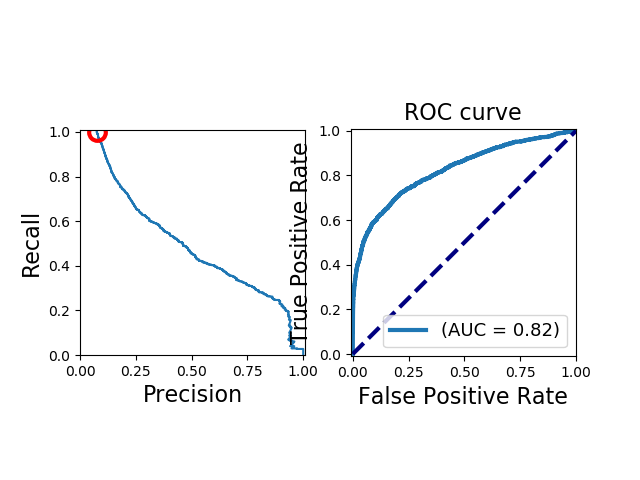

In [35]:
#### plot curves to see results
%matplotlib notebook
import matplotlib.pyplot as plt

#### precision-recall curve
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

fig, (ax1, ax2) = plt.subplots(1, 2)
# plt.figure()
# ax1.figure()
ax1.set_xlim([0.0, 1.01])
ax1.set_ylim([0.0, 1.01])
ax1.plot(precision, recall, label='Precision-Recall Curve')
ax1.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
ax1.set_xlabel('Precision', fontsize=16)
ax1.set_ylabel('Recall', fontsize=16)
ax1.set_aspect('equal')
# plt.show()

#### roc curve
# plt.figure()
ax2.set_xlim([-0.01, 1.00])
ax2.set_ylim([-0.01, 1.01])
ax2.plot(fpr_lr, tpr_lr, lw=3, label='(AUC = {:0.2f})'.format(roc_auc_lr))
ax2.set_xlabel('False Positive Rate', fontsize=16)
ax2.set_ylabel('True Positive Rate', fontsize=16)
ax2.set_title('ROC curve', fontsize=16)
ax2.legend(loc='lower right', fontsize=13)
ax2.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax2.set_aspect('equal')
plt.show()

In [71]:
clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [ ]:
#### do the final step
dftest=pd.read_csv('test.csv')
dftest=dftest.set_index('ticket_id')
Xf=dftest[usecols]

#### make dummy variables out of categorical features
Xf_tmp=pd.get_dummies(Xf[dum_col])
Xf_new=Xf[Xf.columns[np.in1d(Xf.columns,dum_col,invert=True)]].join(Xf_tmp)

#### remove columns that weren't in the training
id_rm=np.in1d(Xf_new.columns,X_train.columns)
Xf_new2=Xf_new[Xf_new.columns[id_rm]]
Xf_new2.columns

#### add any columns that were in training and aren't in test?
id_add=np.in1d(X_train.columns,Xf_new2.columns,invert=True)
kwargs={} # ugly but I guess it works
for colname in X_train.columns[id_add]:
    kwargs[colname]=0

Xf_new2=Xf_new2.assign(**kwargs)

#### scale data with the already fitted scaler
Xf_scaled = scaler.transform(Xf_new2)

#### calculate probabilities
y_proba_f=clf.predict_proba(Xf_scaled)

ans=pd.Series( y_proba_f[:,1], index=Xf_new2.index, dtype='float32')
ans.name='compliance'

<IPython.core.display.Javascript object>


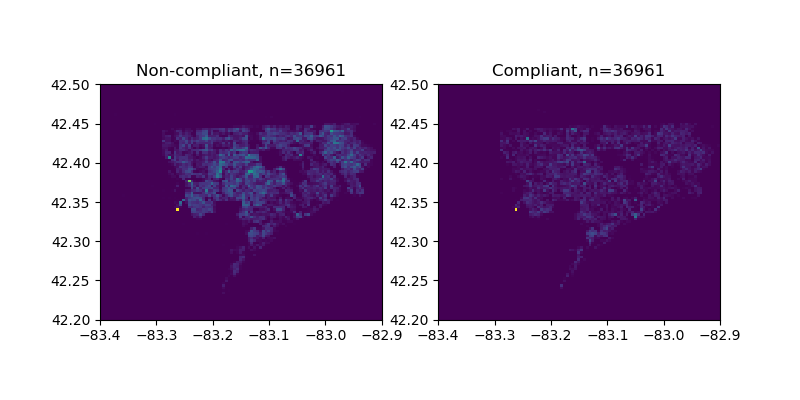

<IPython.core.display.Javascript object>


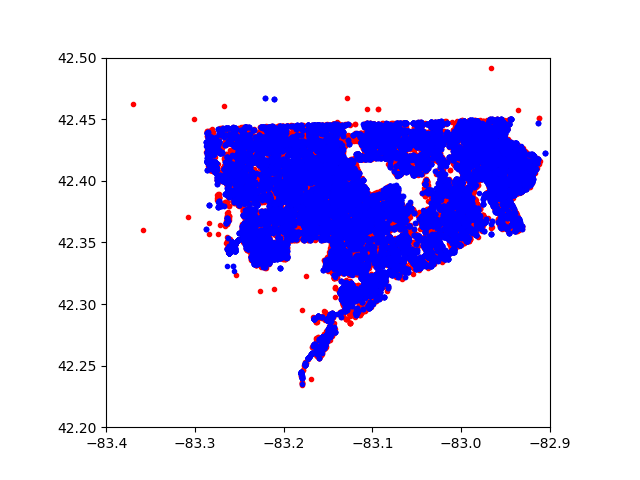

/Users/ulberg/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [36]:
#### plot data in different ways
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

itrain0=y_train==0
itrain1=y_train==1
lon1=-83.4
lon2=-82.9
lat1=42.2
lat2=42.5
xedges=np.linspace(lon1,lon2,100)
yedges=np.linspace(lat1,lat2,100)

H, xedges, yedges = np.histogram2d(X_train['lon'][itrain0], X_train['lat'][itrain0], bins=(xedges,yedges))
H1, xedges1, yedges1 = np.histogram2d(X_train['lon'][itrain1], X_train['lat'][itrain1], bins=(xedges,yedges))

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121)
ax.set_title('Non-compliant, n={:d}'.format(sum(itrain0)))
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, np.transpose(H))
ax.set_aspect(1/np.cos(44* np.pi / 180))

ax = fig.add_subplot(122)
ax.set_title('Compliant, n={:d}'.format(sum(itrain1)))
# X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, np.transpose(H1))
ax.set_aspect(1/np.cos(44* np.pi / 180))

plt.show()

fig2=plt.figure()

plt.xlim([lon1, lon2])
plt.ylim([lat1, lat2])
plt.plot(X_train['lon'][itrain0], X_train['lat'][itrain0],'r.')
plt.plot(X_train['lon'][itrain1], X_train['lat'][itrain1],'b.')
# plt.xlabel('False Positive Rate', fontsize=16)
# plt.ylabel('True Positive Rate', fontsize=16)
# plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
# plt.legend(loc='lower right', fontsize=13)
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect(1/np.cos(44* np.pi / 180))
plt.show()

In [811]:
X_train.head()

,late_fee,discount_amount,fine_amount,judgment_amount,lat,lon,TimeDiff,issue_month,hearing_month,hearing_day,...,agency_name_Department of Public Works,agency_name_Detroit Police Department,violation_code_19420901,violation_code_19450901,violation_code_19830901,violation_code_20130901,violation_code_20180901,violation_code_22,violation_code_61,violation_code_9
ticket_id,,,,,,,,,,,,,,,,,,,,,
244120,25.0,0.0,250.0,305.0,42.389788,-83.043465,58.986111,3,5.0,3.0,...,0,0,0,0,0,0,0,0,0,1
177644,5.0,0.0,50.0,85.0,42.365074,-83.122724,49.815972,6,7.0,31.0,...,1,0,0,0,0,0,0,0,0,1
51862,10.0,0.0,100.0,140.0,42.357034,-83.231834,74.013889,10,12.0,20.0,...,1,0,0,0,0,0,0,1,0,0
132230,30.0,0.0,300.0,360.0,42.407583,-82.970646,28.916667,8,9.0,11.0,...,0,0,0,0,0,0,0,0,0,1
19853,10.0,0.0,100.0,140.0,42.443097,-82.989891,101.812500,1,5.0,13.0,...,0,1,0,0,0,0,0,1,0,0


In [148]:
y_train.value_counts()

0.0    111231
1.0      8677
Name: compliance, dtype: int64

In [493]:
# dfOG['hearing_date'].head()
# dfOG['ticket_issued_date'].head()
# from datetime import datetime
# FMT = '%y-%m-%d %H:%M:%S'
# # datetime.strptime(dfOG['hearing_date'],FMT)-datetime.strptime(dfOG['ticket_issued_date'],FMT)
# tdiff=pd.to_datetime(dfOG['hearing_date'])-pd.to_datetime(dfOG['ticket_issued_date'])
# tdiff=tdiff.dt.total_seconds()/86400


In [497]:
dfOG['late_fee'].value_counts()


0.0       105884
25.0       79621
5.0        17655
10.0       12516
20.0       11354
50.0        6545
100.0       4803
350.0       3785
30.0        3680
250.0       1506
2.5         1223
12.5         723
150.0        251
75.0         217
1000.0       195
35.0         126
500.0         85
120.0         40
40.0          36
200.0         14
700.0         13
60.0          10
300.0          4
22.0           3
9.5            2
175.0          2
16.0           2
125.0          2
0.1            1
15.0           1
800.0          1
67.7           1
17.0           1
269.5          1
65.5           1
97.0           1
45.0           1
Name: late_fee, dtype: int64

In [556]:
X_train.head()

,late_fee,discount_amount,fine_amount,judgment_amount,lat,lon,TimeDiff,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,"agency_name_Buildings, Safety Engineering & Env Department",agency_name_Department of Public Works,agency_name_Detroit Police Department
ticket_id,,,,,,,,,,,,,,
30780,25.0,0.0,250.0,305.0,42.386796,-83.199550,152.875000,0,0,1,0,1,0,0
117181,25.0,0.0,250.0,305.0,42.444537,-83.099722,32.000000,0,0,1,0,1,0,0
191078,25.0,0.0,250.0,305.0,42.373659,-83.095418,61.989583,0,0,1,0,1,0,0
65029,0.0,0.0,250.0,280.0,42.418947,-83.060421,21.131944,0,1,0,0,1,0,0
242980,25.0,0.0,250.0,305.0,42.385498,-83.116482,85.274306,0,0,1,0,1,0,0


In [558]:
dfOG.columns

Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance', 'TimeDiff',
       'address', 'lat', 'lon'],
      dtype='object')

In [638]:
dcount={}
colnames=dfOG.columns
for colname in colnames:
    dcount[colname]=len(dfOG[colname].value_counts())
    
dcount

{'agency_name': 5,
 'inspector_name': 173,
 'violator_name': 119992,
 'violation_street_number': 19175,
 'violation_street_name': 1791,
 'violation_zip_code': 0,
 'mailing_address_str_number': 15826,
 'mailing_address_str_name': 37896,
 'city': 5184,
 'state': 59,
 'zip_code': 4251,
 'non_us_str_code': 2,
 'country': 5,
 'ticket_issued_date': 86979,
 'hearing_date': 6222,
 'violation_code': 235,
 'violation_description': 258,
 'disposition': 9,
 'fine_amount': 43,
 'admin_fee': 2,
 'state_fee': 2,
 'late_fee': 37,
 'discount_amount': 13,
 'clean_up_cost': 1,
 'judgment_amount': 57,
 'payment_amount': 533,
 'balance_due': 606,
 'payment_date': 2307,
 'payment_status': 3,
 'collection_status': 1,
 'grafitti_status': 1,
 'compliance_detail': 10,
 'compliance': 2,
 'TimeDiff': 33217,
 'hearing_month': 12,
 'issue_month': 12,
 'hearing_day': 31,
 'issue_day': 31,
 'hearing_dayofweek': 6,
 'issue_dayofweek': 7,
 'address': 95598,
 'lat': 78694,
 'lon': 87249}

In [637]:
# pd.to_datetime(dfOG['ticket_issued_date']).dt.weekday

In [730]:
# vds=dfOG['violation_description'].unique()
dfOG['violation_description'].value_counts()


Failure of owner to obtain certificate of compliance                                                                                                                                                                99091
Failure to obtain certificate of registration for rental property                                                                                                                                                   43471
Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste                                                                                                                28719
Excessive weeds or plant growth one- or two-family dwelling or commercial Building                                                                                                                                  22536
Allowing bulk solid waste to lie or accumulate on or about the premises                                                         

In [736]:
st='61-111.0100/32.0066'

# st.replace('/','.').replace('-','.').split('.')
st.split('-')

# dfplay=dfOG.copy()
# dfplay['violation_code'].apply(lambda x: x.split('-')[0])
dfOG.columns

Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance', 'TimeDiff',
       'hearing_month', 'issue_month', 'hearing_day', 'issue_day',
       'hearing_dayofweek', 'issue_dayofweek', 'address', 'lat', 'lon'],
      dtype='object')

In [870]:
dfplay=dfOG.copy()
dfplay.violation_description=dfplay.violation_description.astype("category").cat.codes
dfplay.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,...,TimeDiff,hearing_month,issue_month,hearing_day,issue_day,hearing_dayofweek,issue_dayofweek,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,...,369.951389,3.0,3,21.0,16,0.0,1,"2900 TYLER, DETROIT MI",42.390729,-83.124268
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,...,378.041667,5.0,4,6.0,23,4.0,4,"4311 CENTRAL, DETROIT MI",42.326937,-83.135118
22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,...,336.868056,3.0,4,29.0,26,1.0,0,"1449 LONGFELLOW, DETROIT MI",42.380516,-83.096069
22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,...,NaN,NaN,4,NaN,26,NaN,0,"1441 LONGFELLOW, DETROIT MI",42.380570,-83.095919
22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,...,336.895833,3.0,4,29.0,26,1.0,0,"2449 CHURCHILL, DETROIT MI",42.145257,-83.208233


In [872]:
# pd.crosstab(dfOG.judgment_amount, dfOG.compliance, margins=True).apply(lambda r: r/r.sum(), axis=1)
ctTot=pd.crosstab(dfplay.violation_description, dfplay.compliance, margins=True)
# ctTot

In [873]:
# pd.crosstab(dfOG.state, dfOG.compliance, margins=True).apply(lambda r: 2*r/r.sum(), axis=1)

# pd.crosstab(dfOG.violation_description, dfOG.compliance, normalize='index', margins=True).sort_values(1.0, ascending=False)
ctNorm=pd.crosstab(dfplay.violation_description, dfplay.compliance, normalize='index', margins=True)


<IPython.core.display.Javascript object>


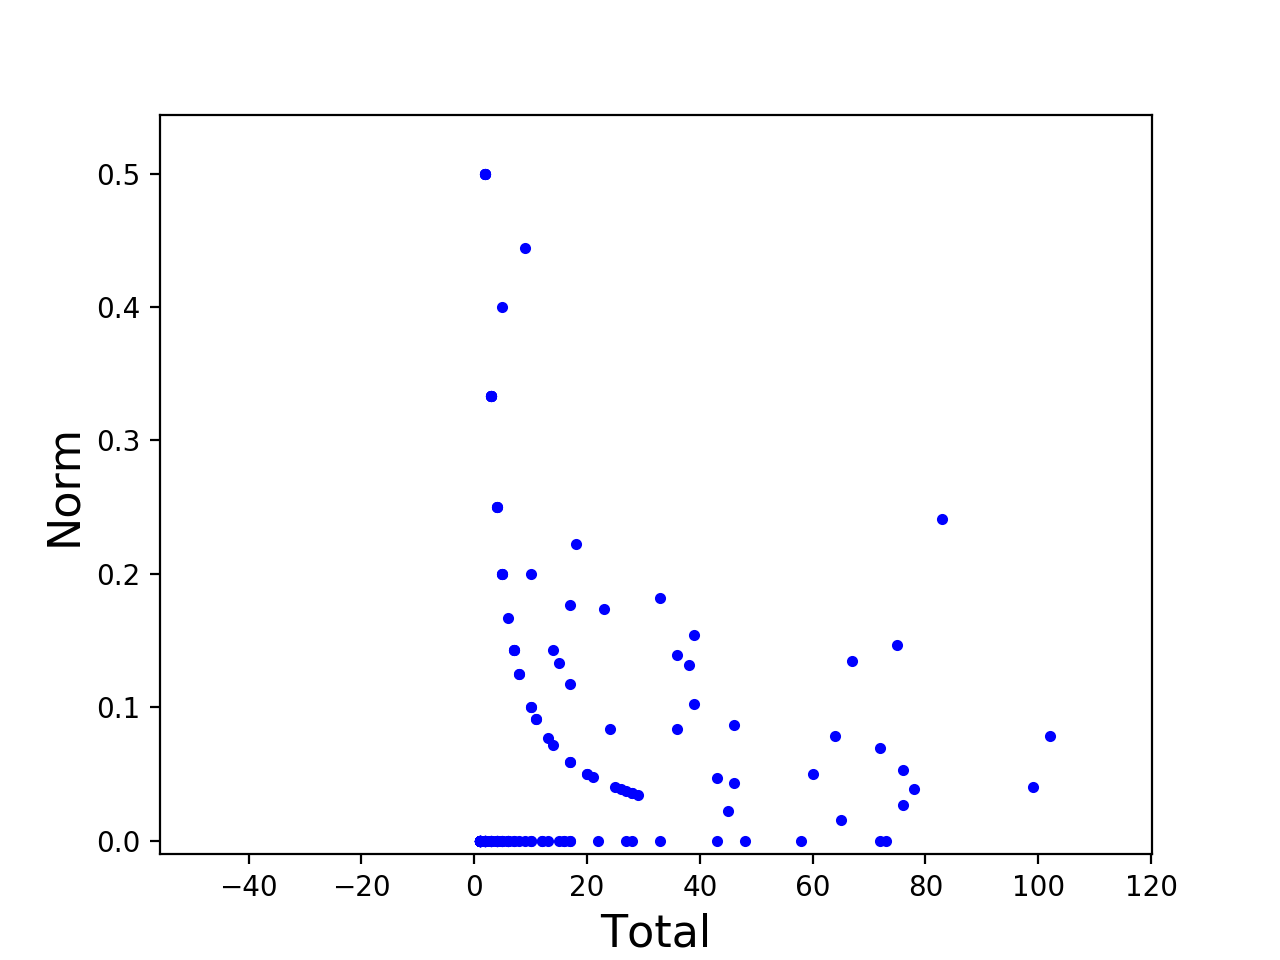

In [874]:
%matplotlib notebook
import matplotlib.pyplot as plt

# fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure()
# ax1.figure()
# plt.xlim([0.0, 1.01])
# plt.ylim([0.0, 1.01])
# plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(ctTot['All'], ctNorm[1.0], 'b.')
plt.xlabel('Total', fontsize=16)
plt.ylabel('Norm', fontsize=16)
# plt.aspect('equal')
plt.show()

In [841]:
#### split the violation categories by ones that have 250 or more
i75tmp=ctTot[1.0]>75

ctTot.index[i75tmp]
#  pd.Categorical(df.cc)
iMajor=list(ctTot.index[i75tmp])
iMajor

[0, 4, 50, 75, 77, 123, 149, 159, 163, 171, 231, 232, 256]

In [846]:
# ctTot.index.astype("category").cat.codes
dfplay.violation_description=dfplay.violation_description.apply(lambda x: x if x in iMajor else -1)
dfplay.violation_description=dfplay.violation_description.astype('category')
dfplay.violation_description.unique()

[77, -1, 231, 163, 4, ..., 232, 50, 123, 0, 149]
Length: 14
Categories (14, int64): [77, -1, 231, 163, ..., 50, 123, 0, 149]

In [892]:
#### make violation_description for both

# dftest.violation_description.unique()
dfplay1=dfOG.copy()
dfplay2=dftest.copy()

## merge them temporarily
dfplay1['test']=0
dfplay2['test']=1
dfplay0=pd.concat([dfplay1,dfplay2],sort=True)
dfplay0.violation_description=dfplay0.violation_description.astype("category").cat.codes

## this shows how many of each description there are, only choose the ones with a lot
tot=dfplay0.violation_description.value_counts() # already sorted
iMajor=list(tot.index[tot>400]) # these are the label codes for the ones with a lot of hits

## keep the good ones, label the rest the same
dfplay0.violation_description=dfplay0.violation_description.apply(lambda x: x if x in iMajor else -1)
dfplay0.violation_description=dfplay0.violation_description.astype('category')


tmp1=dfplay0[dfplay0.test==0]
tmp2=dfplay0[dfplay0.test==1]
print('({:d},{:d}) - ({:d},{:d})'.format(len(dfplay1),len(dfplay2),len(tmp1),len(tmp2)))
# pd.get_dummies(dfplay0['violation_description'])

(250306,61001) - (250306,61001)


In [1087]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.utils import resample

#### read model
df=pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory=False)
df=df.set_index('ticket_id')
dfOG=df

#### read the test model so we match columns
dftest=pd.read_csv('test.csv')
dftest=dftest.set_index('ticket_id')

#### join train and test temporarily to create new classes
dfplay1=dfOG.copy()
dfplay2=dftest.copy()
dfplay1['test']=0
dfplay2['test']=1

dfplay0=pd.concat([dfplay1,dfplay2])

#### create new feature - time difference between ticket and hearing dates
tdiff=pd.to_datetime(dfplay0['hearing_date'])-pd.to_datetime(dfplay0['ticket_issued_date'])
dfplay0['TimeDiff']=tdiff.dt.total_seconds()/86400

#### add month feature for issue and hearing date, also day and weekday
dfplay0['hearing_month']=pd.to_datetime(dfplay0['hearing_date']).dt.month
dfplay0['issue_month']=pd.to_datetime(dfplay0['ticket_issued_date']).dt.month

dfplay0['hearing_day']=pd.to_datetime(dfplay0['hearing_date']).dt.day
dfplay0['issue_day']=pd.to_datetime(dfplay0['ticket_issued_date']).dt.day

dfplay0['hearing_dayofweek']=pd.to_datetime(dfplay0['hearing_date']).dt.weekday
dfplay0['issue_dayofweek']=pd.to_datetime(dfplay0['ticket_issued_date']).dt.weekday

#### change the violation code
dfplay0['violation_code']=dfplay0['violation_code'].apply(lambda x: x.split('-')[0])

#### change violation description
dfplay0.violation_description=dfplay0.violation_description.astype("category").cat.codes

## this shows how many of each description there are, only choose the ones with a lot
tot=dfplay0.violation_description.value_counts() # already sorted
iMajor=list(tot.index[tot>400]) # these are the label codes for the ones with a lot of hits

## keep the good ones, label the rest the same
dfplay0.violation_description=dfplay0.violation_description.apply(lambda x: x if x in iMajor else -1)
dfplay0.violation_description=dfplay0.violation_description.astype('category')

#### read latlon, addresses
latlon_df=pd.read_csv('latlons.csv')
add_df=pd.read_csv('addresses.csv')
add_df['address'] = add_df['address'].str.upper()

#### merge latlon, addresses on addresses column
latlon_df['address'] = latlon_df['address'].str.upper()
df_info=add_df.merge(latlon_df,left_on='address',right_on='address')
df_info=df_info.set_index('ticket_id')

#### add lat/lon information
dfplay0=dfplay0.merge(df_info,left_index=True,right_index=True, how='left')

#### split train and test back to original before training the model
dfOG=dfplay0[dfplay0.test==0]
dftest=dfplay0[dfplay0.test==1]

#### define features to use and clean model
target='compliance'
#     usecols=['disposition', 'agency_name', 'late_fee', 'fine_amount']
usecols=['disposition', 'agency_name', 'late_fee','discount_amount', 'fine_amount','judgment_amount','lat','lon','TimeDiff','issue_month','hearing_month','hearing_day','hearing_dayofweek','issue_dayofweek','violation_description']

newtmp=usecols.copy()
newtmp.append(target)

df=dfOG[newtmp]
df=df.dropna()
dftest=dftest[newtmp]

#### fill nans in test dataset with the most common from training
fillnames=['lat','lon','TimeDiff','issue_month','hearing_month','hearing_day','hearing_dayofweek']
# lat has 5 nas
# lon has 5 nas
# TimeDiff has 2197 nas
# issue_month has 0 nas
# hearing_month has 2197 nas
# hearing_day has 2197 nas
# hearing_dayofweek has 2197 nas
from statistics import mode 
for fillname in fillnames:
    # first get most common from training
    fillval=df[fillname].mode()[0]
    dftest[fillname]=dftest[fillname].fillna(fillval)

#### split into X and y
colnames=df.columns
X=df[colnames[:-1]]
y_train=df[colnames[-1]]

#### make dummy variables out of categorical features
X_new=pd.get_dummies(X[usecols])
Xf=pd.get_dummies(dftest[usecols])

#### find columns that aren't shared and remove them
id_rmf=np.in1d(Xf.columns,X_new.columns) # bad variable naming, i know
id_rm=np.in1d(X_new.columns,Xf.columns)

Xf2=Xf[Xf.columns[id_rmf]]
X_train=X_new[X_new.columns[id_rm]]

#### join the training set temporarily to do resampling
dfre=X_train.copy()
dfre=dfre.assign(compliance=y_train)

#### up and downsample the minority and majority
import math
df_majority=dfre[dfre.compliance==0]
df_minority=dfre[dfre.compliance==1]

# find length = log mean of the two
base=2 # doesn't matter
lnew=base ** ((math.log(len(df_majority),base)+math.log(len(df_minority),base))/2)

df_minority_upsampled=resample(df_minority,replace=True,n_samples=round(lnew))
df_majority_downsampled=resample(df_majority,replace=False,n_samples=round(lnew))

df_resampled=pd.concat([df_majority_downsampled,df_minority_upsampled])
df=df_resampled.copy()

#### resplit X and y, only if resampling was performed
X_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]

#### scale the data so things are nice
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

#### apply the classifier to scaled data
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, max_features=1.0, max_depth=6)
# 'max_features': 1.0, 'max_depth': 6, 'learning_rate': 0.2, 'n_estimators': 200
#     clf = GradientBoostingClassifier().fit(X_train_scaled, y_train)
# clf = RandomForestClassifier().fit(X_train_scaled, y_train)
# clf = DecisionTreeClassifier(max_depth=2).fit(X_train_scaled, y_train)
# clf = LogisticRegression().fit(X_train_scaled, y_train)

clf.fit(X_train_scaled,y_train)

## what is the result from the training data?
y_proba=clf.predict_proba(X_train_scaled)
#### calculate stuff for roc curve
fpr_lr, tpr_lr, _ = roc_curve(y_train, y_proba[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

print('Training AUC: {:.3f}'.format(roc_auc_lr))

#### calculate predicted probabilities with the chosen classifier
Xf_scaled=scaler.transform(Xf2)
y_proba_f=clf.predict_proba(Xf_scaled)

ans=pd.Series( y_proba_f[:,1], index=Xf2.index, dtype='float32')
ans.name='compliance'
ans

/Users/ulberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



Training AUC: 0.905


ticket_id
284932    0.780266
285362    0.079961
285361    0.525349
285338    0.466287
285346    0.626419
285345    0.471125
285347    0.647510
285342    0.979331
285530    0.356897
284989    0.216908
285344    0.614196
285343    0.138422
285340    0.191298
285341    0.674594
285349    0.635156
285348    0.495823
284991    0.216908
285532    0.157669
285406    0.207340
285001    0.278254
285006    0.065222
285405    0.133950
285337    0.215947
285496    0.394010
285497    0.324269
285378    0.126567
285589    0.114793
285585    0.347965
285501    0.463405
285581    0.139843
            ...   
376367    0.191707
376366    0.313914
376362    0.833862
376363    0.758064
376365    0.191707
376364    0.313914
376228    0.479930
376265    0.475523
376286    0.605713
376320    0.227855
376314    0.279920
376327    0.801512
376385    0.801089
376435    0.971117
376370    0.973651
376434    0.323773
376459    0.546490
376478    0.022347
376473    0.373691
376484    0.217876
376482    0.262127
37

In [1077]:
colnames=Xf2.columns
for colname in colnames:
    print('{:s} has {:d} nas'.format(colname,Xf2[colname].isna().sum()))

disposition has 0 nas
agency_name has 0 nas
late_fee has 0 nas
discount_amount has 0 nas
fine_amount has 0 nas
judgment_amount has 0 nas
lat has 5 nas
lon has 5 nas
TimeDiff has 2197 nas
issue_month has 0 nas
hearing_month has 2197 nas
hearing_day has 2197 nas
hearing_dayofweek has 2197 nas
issue_dayofweek has 0 nas
violation_description has 0 nas
compliance has 61001 nas


In [1073]:

from statistics import mode 
Xf2['lat'].mode()

0    42.34173
dtype: float64

In [1085]:
pp=dftest.copy()
fillnames=['lat','lon','TimeDiff','issue_month','hearing_month','hearing_day','hearing_dayofweek']

from statistics import mode 
for fillname in fillnames:
    # first get most common from training
    fillval=df[fillname].mode()[0]
    print('Adding {} to {}'.format(fillval,fillname))
    pp[fillname]=pp[fillname].fillna(fillval)

Adding 42.3417302 to lat
Adding -83.2622709 to lon
Adding 27.104166666666668 to TimeDiff
Adding 3 to issue_month
Adding 8.0 to hearing_month
Adding 7.0 to hearing_day
Adding 1.0 to hearing_dayofweek


In [1086]:
pp.hearing_dayofweek.isna().sum()

# df[fillname].mode()[0]

0